# Cornershop

In [1]:
# %load basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
import time
start = time.time()

In [3]:
liga = '/home/ef/Desktop/Prueba SQL- Cornershop'
product = pd.read_excel(liga + '/Order_product.xlsx')
orders = pd.read_excel(liga + '/Orders.xlsx')
shoppers = pd.read_excel(liga + '/Shoppers.xlsx')
stores = pd.read_excel(liga + '/Storebranch.xlsx')

## Cantidad de pedidos por día de la semana

<AxesSubplot:xlabel='on_demand', ylabel='dow'>

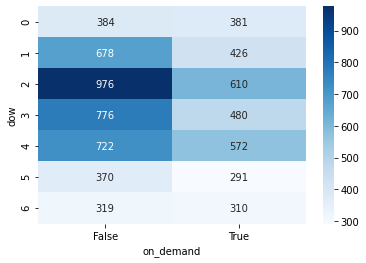

In [4]:
import seaborn as sns
sns.heatmap(orders.pivot_table(index = 'dow', 
                               columns = 'on_demand', 
                               values = 'lat',
                               aggfunc = 'count'), 
            annot = True, 
            fmt = '.0f',
            cmap = 'Blues')

## Cantidad promedio de productos distintos que tiene cada pedido agrupado por tienda 

In [5]:
orders.merge(product.drop_duplicates().groupby('order_id')['product_id'].count().reset_index(), 
             on = 'order_id',
             how = 'left'
            ).dropna(subset = ['product_id']
                    ).merge(stores, 
                            on = 'store_branch_id',
                            how = 'left'
                           ).groupby('store'
                                    )['product_id'].mean().reset_index().sort_values(by = 'product_id', 
                                                                                     ascending = False
                                                                                    ).reset_index(drop = True).rename(columns = {'store':'Tienda',
                                                                                                                                 'product_id':'Prom_prod_dist'})

,Tienda,Prom_prod_dist
0,60e4c4e1c1a8bc79123738227b9d0b08,22.47
1,387d4a5b65cf4bf00ad805c4b00eed01,19.93
2,452ae015bf846e1d2932b7ea15720d64,18.42
3,451eb58b96f0a36f31d2beebd1c9a7a8,16.57
4,a3bed30221372366bcd9b9779f395d0b,7.63
5,0fae7b61265bc7ca4ce4d81440b62501,7.16
6,044d56734d20e04984d846dade6d39f3,5.68
7,1174a0029cadfa449af46c53b1c90fbe,5.00
8,a08814af6c2379a480e261b3598ddbd5,4.94
9,6447951cd071f6f045fd4e6194920926,4.47


## Found rate promedio de los pedidos agrupados por formato de producto y día de la semana

In [6]:
## Se crea el found rate
product['FR'] = product['quantity_found'] / product['quantity']
product[product['buy_unit'] == 'KG']['FR'].describe([x/10 for x in range(2,10,2)])

count   26332.00
mean        1.66
std         2.85
min         0.00
20%         0.92
40%         1.01
50%         1.05
60%         1.12
80%         1.40
max       104.50
Name: FR, dtype: float64

In [7]:
## Se omiten outliers mediante el método IQR (pero con menos sensibilidad)
def outlier(df, x , p = 0.2):
    var = df[x]
    q1 = var.quantile(p/2)
    q3 = var.quantile(1 - p/2)
    iqr = q3 - q1
    df = df[(var.isnull()) | ((var >= q1 - 1.5*iqr) & (var <= q3 + 1.5*iqr))].copy()
    df.reset_index(drop = True, inplace = True)
    return df

product = outlier(product,'FR')
product['FR'].describe()

count   118897.00
mean         0.89
std          0.38
min          0.00
25%          1.00
50%          1.00
75%          1.00
max          2.71
Name: FR, dtype: float64

### Respuesta

In [8]:
product.merge(orders, 
              on = 'order_id',
              how = 'left')[['buy_unit','FR','dow']
                           ].pivot_table(index = 'dow', 
                                         columns = 'buy_unit',
                                         values = 'FR',
                                         aggfunc = 'mean').style.format("{:.2%}")

buy_unit,KG,UN
dow,,
0,105.77%,83.54%
1,107.43%,84.63%
2,106.79%,84.88%
3,105.02%,84.74%
4,105.72%,84.78%
5,105.62%,84.98%
6,105.87%,84.87%


##  Error promedio y error cuadrático medio de nuestro modelo de estimación para cada hora del día.

In [9]:
from sklearn.metrics import mean_absolute_error
import math

performance = pd.DataFrame()
performance['Hora'] = sorted(np.unique([x.hour for x in orders['promised_time']]))

ep = []
mae = []

for i in range(len(performance)):
    times = orders[[n.hour for n in orders['promised_time']] == performance['Hora'][i]
                  ][['promised_time','actual_time']].copy()
    for col in times.columns:
        times[col] = [(x.hour + 24)*60*60 + x.minute*60 + x.second 
                      if x.hour < 1 else
                      x.hour*60*60 + x.minute*60 + x.second 
                      for x in times[col]]
    times['dif'] = times['actual_time'] - times['promised_time']
    times = outlier(times,'dif')
    ep.append(times['dif'].mean())
    mae.append(mean_absolute_error(times['promised_time']/60, times['actual_time']/60))
    
performance['error_prom'] = [x/60 for x in ep]  
performance['error_abs'] = mae
performance

,Hora,error_prom,error_abs
0,0,-60.00,60.00
1,8,-16.72,22.22
2,9,-29.21,32.93
3,10,-37.05,39.38
4,11,-37.24,39.10
5,12,-38.10,40.65
6,13,-35.87,38.51
7,14,-34.26,37.66
8,15,-32.83,37.01
9,16,-32.49,35.70


In [10]:
## Bonus
from sklearn.metrics import r2_score
times = orders[['promised_time','actual_time']].copy()
for col in times.columns:
    times[col] = [(x.hour + 24)*60*60 + x.minute*60 + x.second 
                  if x.hour < 1 else
                  x.hour*60*60 + x.minute*60 + x.second 
                  for x in times[col]]
'Modelo con precisión: {:.2%}'.format(r2_score(times['promised_time'], times['actual_time']))

'Modelo con precisión: 96.57%'

## Cantidad de pedidos donde el picker_id y el driver_id son distintos

In [1]:
len(np.unique((orders[orders['picker_id'] != orders['driver_id']]['order_id'])))

NameError: name 'np' is not defined

# Fin

In [12]:
import math
def time_exp(x):
    x = str(int(math.floor(x/60))
           ) + " minutos con " + '{:.2f}'.format(60*(x/60 - math.floor(x/60))
                                                ) + " segundos"
    return x

In [13]:
## Tiempo total para correr el notebook
end = time.time()
tiempo_tot = end - start
time_exp(tiempo_tot)

'0 minutos con 12.48 segundos'